## Получение и предобработка данных

In [7]:
import pandas as pd
import numpy as np
import sqlalchemy
from clickhouse_driver import Client

### Подключаемся к Clickhouse для получения данных

In [8]:
client = Client('89.208.84.253',
                port= '59000',
                user='student',
                password='nUrHdn2N',
                secure=False,
                verify=True,
                database='data_analysis',
                compression=False)

In [9]:
query_views = """select *
from data_analysis.views
"""

query_orders = """select *
from data_analysis.orders
"""

result,columns = client.execute(query_views, with_column_types=True)
views = pd.DataFrame(result, columns = [tuple[0] for tuple in columns])

result,columns = client.execute(query_orders, with_column_types=True)
orders = pd.DataFrame(result, columns = [tuple[0] for tuple in columns])

In [10]:
views.head()

,idhash_view,view_dttm,tariff,idhash_order,idhash_client,client_bill_usd,latitude,longitude,del_latitude,del_longitude
0,3105945005,2015-12-06 00:00:02,Эконом,0,35537762,6.04,57.630691,39.888197,57.713856,39.772606
1,2062958078,2015-12-06 00:00:04,Комфорт,0,2920203325,0.00,57.622005,39.878959,0.000000,0.000000
2,2786426058,2015-12-06 00:00:05,Эконом,0,801152436,4.03,55.728050,37.580513,55.669315,37.561047
3,992462937,2015-12-06 00:00:06,Эконом,3777115420,260623123,1.54,57.653202,39.960438,57.647839,39.946285
4,517307460,2015-12-06 00:00:08,Комфорт+,0,2446042259,0.00,57.621269,39.867851,0.000000,0.000000


Добавим для удобства айди пользователя в таблицу заказов

In [11]:
orders['idhash_client'] = orders.drop('idhash_view', axis = 1).join(views.set_index('idhash_order'), on='idhash_order', how = 'left')['idhash_client']

In [12]:
orders.head()

,idhash_order,idhash_view,order_dttm,da_dttm,rfc_dttm,cc_dttm,finish_dttm,cancel_dttm,status,idhash_client
0,3777115420,95199865,2015-12-06 00:00:09,2015-12-06 00:00:09,2015-12-06 00:03:31,2015-12-06 00:04:59,2015-12-06 00:10:06,NaT,CP,2.606231e+08
1,2983673012,3853062057,2015-12-06 00:00:11,2015-12-06 00:00:12,NaT,NaT,NaT,2015-12-06 00:01:26,CC,NaN
2,2177076394,147233410,2015-12-06 00:00:26,2015-12-06 00:00:37,2015-12-06 00:04:31,2015-12-06 00:07:06,2015-12-06 00:12:29,NaT,CP,1.419240e+09
3,1997846256,518227239,2015-12-06 00:00:32,2015-12-06 00:00:41,2015-12-06 00:04:04,2015-12-06 00:06:08,2015-12-06 00:17:11,NaT,CP,3.243818e+09
4,1893504594,3623774808,2015-12-06 00:01:07,2015-12-06 00:04:46,2015-12-06 00:11:35,2015-12-06 00:13:01,2015-12-06 00:29:43,NaT,CP,2.978411e+09


### RFM-сегментация

In [13]:
views['client_bill_rub'] =  views['client_bill_usd'] * 75

Для RFM-сегментации нам нужна информация о:
* дате последнего заказа
* частоте заказов
* сумме заказов

Заказ будем считать совершенным, если человека без происшествий довезли до пункта назначения, то есть если имеется дата завершения поездки колонки "finish_dttm" таблицы с заказами:

In [14]:
completed_orders = orders.dropna(subset = ['finish_dttm'])

Приджоиним информацию о сумме каждого заказа из views:

In [15]:
completed_orders = completed_orders.drop(['idhash_view', 'idhash_client'], axis = 1).join(views.set_index('idhash_order'), on='idhash_order', how = 'left')

Оставляем только нужные нам для сегментации колонки:

In [16]:
completed_orders = completed_orders.drop(['da_dttm', 'rfc_dttm', 'cc_dttm', 'cancel_dttm', 'status', 'idhash_view', 'client_bill_usd', 'latitude', 'longitude', 'del_latitude', 'del_longitude'], axis = 1)

Добавляем колонку в временем, которое прошло с момента заказа в часах

In [17]:
def get_recency(order_date):
    TODAY = pd.to_datetime('2015-12-20 00:00:00')
    return round((TODAY - order_date).total_seconds() / 3600 / 24, 2)


completed_orders['days_since_last_order'] =  completed_orders['order_dttm'].apply(get_recency)

In [18]:
completed_orders.head()

,idhash_order,order_dttm,finish_dttm,view_dttm,tariff,idhash_client,client_bill_rub,days_since_last_order
0,3777115420,2015-12-06 00:00:09,2015-12-06 00:10:06,2015-12-06 00:00:06,Эконом,2.606231e+08,115.5,14.0
2,2177076394,2015-12-06 00:00:26,2015-12-06 00:12:29,2015-12-06 00:00:25,Эконом,1.419240e+09,141.0,14.0
3,1997846256,2015-12-06 00:00:32,2015-12-06 00:17:11,2015-12-06 00:00:26,Эконом,3.243818e+09,384.0,14.0
4,1893504594,2015-12-06 00:01:07,2015-12-06 00:29:43,2015-12-06 00:00:48,Комфорт+,2.978411e+09,529.5,14.0
9,1786344293,2015-12-06 00:02:09,2015-12-06 00:18:00,2015-12-06 00:02:02,Эконом,1.583693e+09,208.5,14.0


#### Определим границы наших сегментов

Сгруппируем по пользователем и:
* поставим в колонку recent - самый недавний заказ
* просуммируем все заказы
* посчитаем количество всех заказов

In [19]:
grouped = completed_orders.groupby('idhash_client').agg(
    {'client_bill_rub': ['mean', 'count'],
     'days_since_last_order': 'min'}
)
monetary = grouped[('client_bill_rub', 'mean')]
frequency = grouped[('client_bill_rub', 'count')]
recency = grouped[('days_since_last_order', 'min')]

borders = {}

##### monetary

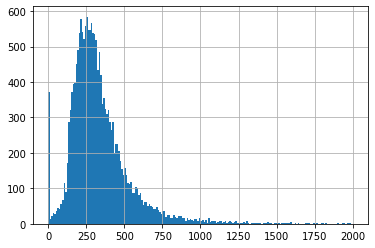

In [21]:
import matplotlib.pyplot as plt

monetary.hist(bins = 200, range = (0, 2000))
plt.show()


Большое скопление заказов с нулевой суммой выбросом не считаю, так как это люди, оплатившие поездку бонусами (я надеюсь), а значит это тоже наши клиенты, которые в данной поездке пошли нам в убыток.

Применим равномерное сегментирование по диапазонам значений:

In [22]:
range = monetary.quantile(0.97) - monetary.quantile(0.03)
step = range / 3

border_1 = monetary.quantile(0.03) + step
border_2 = border_1 + step

print('{} - {}   ~{}%'.format(monetary.min(), border_1, 58))
print('{} - {}   ~{}%'.format(border_1, border_2, 32))
print('{} - {}   ~{}%'.format(border_2, monetary.max(), 10))

borders['monetary'] = [[monetary.min(), border_1], [border_1, border_2], [border_2, monetary.max()]]

0.0 - 321.0   ~58%
321.0 - 572.25   ~32%
572.25 - 23015.25   ~10%


##### frequency

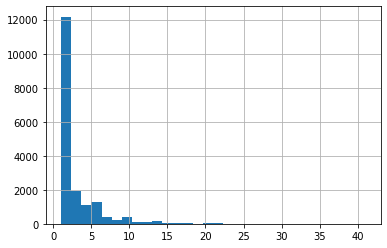

In [23]:
frequency.hist(bins = 30)
plt.show()

Определим границы по фиксированным диапазон, то есть самостоятельно:

In [24]:
border_1 = 1.01
border_2 = 3.01

print('Диапазон количества поездок:')
print('{} - {}   ~{}%'.format(frequency.min(), border_1, 46))
print('{} - {}   ~{}%'.format(border_1, border_2, 77 - 46))
print('{} - {}   ~{}%'.format(border_2, frequency.max(), 100 - 77))

borders['frequency'] = [[frequency.min(), border_1], [border_1, border_2], [border_2, frequency.max()]]

Диапазон количества поездок:
1 - 1.01   ~46%
1.01 - 3.01   ~31%
3.01 - 41   ~23%


##### recency

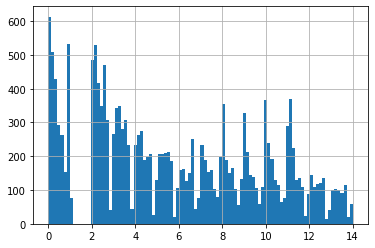

In [25]:
recency.hist(bins = 100)
plt.show()

In [26]:
recency.describe()

count    18104.000000
mean         5.792154
std          3.951559
min          0.000000
25%          2.470000
50%          5.220000
75%          9.150000
max         14.000000
Name: (days_since_last_order, min), dtype: float64

In [27]:
border_1 = 2.01
border_2 = 7.01

print('{} - {}   ~{}%'.format(recency.min(), border_1, 16))
print('{} - {}   ~{}%'.format(border_1, border_2, 60 - 16))
print('{} - {}   ~{}%'.format(border_2, recency.max(), 100 - 60))

borders['recency'] = [[recency.min(), border_1], [border_1, border_2], [border_2, recency.max()]]

0.0 - 2.01   ~16%
2.01 - 7.01   ~44%
7.01 - 14.0   ~40%


#### Разобьем на сегменты и добавим сегменты к изначальной таблице orders к пользователям

In [28]:
grouped.columns = ['monetary', 'frequency', 'recency']

In [29]:
def get_monetary_rating(value):
    if value < borders['monetary'][0][1]:
        return 1
    elif value < borders['monetary'][1][1]:
        return 2
    elif value <= borders['monetary'][2][1]:
        return 3
    return -1

def get_frequency_rating(value):
    if value < borders['frequency'][0][1]:
        return 1
    elif value < borders['frequency'][1][1]:
        return 2
    elif value <= borders['frequency'][2][1]:
        return 3
    return -1

def get_recency_rating(value):
    if value < borders['recency'][0][1]:
        return 3
    elif value < borders['recency'][1][1]:
        return 2
    elif value <= borders['recency'][2][1]:
        return 1
    return -1

def get_rfm_description(row):
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 1:
        return "111 Потерянные экономные"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 2:
        return "112 Одноразовые"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 3:
        return "113 Одноразовые"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 1:
        return "121 Уходящие редкие"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 2:
        return "122 Уходящие редкие"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 3:
        return "123 Уходящие редкие"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 1:
        return "131 Уходящие постоянные"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 2:
        return "132 Уходящие хорошие постоянные"
    if row['recency_RFM'] == 1 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 3:
        return "133 Уходящие VIP"
    
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 1:
        return "211 Спящие разовые с маленьким чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 2:
        return "212 Спящие разовые с маленьким чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 3:
        return "213 Спящие разовые с маленьким чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 1:
        return "221 Спящие редкие с маленьким чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 2:
        return "222 Спящие редкие со средним чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 3:
        return "223 Спящие редкие с высоким чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 1:
        return "231 Спящие постоянные с маленьким чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 2:
        return "232 Спящие постоянные со средним чеком"
    if row['recency_RFM'] == 2 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 3:
        return "233 Спящие постоянные с высоким чеком"
    
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 1:
        return "311 Новички с маленьким чеком"
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 2:
        return "312 Новички со средним чеком"
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 1 and row['monetary_RFM'] == 3:
        return "313 Новички с высоким чеком. Потенциальные VIP."
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 1:
        return "321 Постоянные с маленьким чеком"
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 2:
        return "322 Редкие со средним чеком"
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 2 and row['monetary_RFM'] == 3:
        return "323 Постоянные с высоким чеком"
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 1:
        return "331 Постоянные с маленьким чеком"
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 2:
        return "332 Постоянные со средним чеком"
    if row['recency_RFM'] == 3 and row['frequency_RFM'] == 3 and row['monetary_RFM'] == 3:
        return "333 VIP"
    
    

grouped['monetary_RFM'] = grouped['monetary'].apply(get_monetary_rating)
grouped['frequency_RFM'] = grouped['frequency'].apply(get_frequency_rating)
grouped['recency_RFM'] = grouped['recency'].apply(get_recency_rating)
grouped['RFM_description'] = grouped.apply(get_rfm_description, axis = 1)

grouped.head()

,monetary,frequency,recency,monetary_RFM,frequency_RFM,recency_RFM,RFM_description
idhash_client,,,,,,,
39262.0,159.25,3,0.05,1,2,3,321 Постоянные с маленьким чеком
48902.0,198.75,1,5.48,1,1,2,211 Спящие разовые с маленьким чеком
199395.0,383.75,3,2.57,2,2,2,222 Спящие редкие со средним чеком
1721255.0,183.00,2,2.01,1,2,2,221 Спящие редкие с маленьким чеком
2825748.0,196.50,1,10.75,1,1,1,111 Потерянные экономные


In [30]:
orders = orders.join(grouped, on = 'idhash_client', how = 'left')
views = views.join(grouped, on = 'idhash_client', how = 'left')

## Считаем метрики с учетом RFM-сегментации

### View2Order
*  ###### по сегментам в динамике по дням
    * группируем по сегментам и дням в сводной таблице кол-во заказов и кол-во просмотров
    * визуализируем 
        * на обычном графике с линиями для каждого из сегментов
* ###### по сегментам в динамике по времени суток (утро-день-вечер-ночь)
    * группируем по сегментам и времени дня в сводной таблице кол-во заказов и кол-во просмотров:
        * добавим в таблицу категоризацию на время дня 
    * визуализируем
        * попробовать мб сделать тип гистограмки для каждого времени дня с соотношением

In [31]:
df = views.join(orders.drop(['idhash_client', 'idhash_view', 'monetary', 'frequency', 'recency', 'monetary_RFM', 'frequency_RFM',
       'recency_RFM', 'RFM_description'], axis = 1).set_index('idhash_order'), on = 'idhash_order', how = 'left')

Чистим таблицу от просмотров, совершенных пользователями, которые никогда ничего не заказывали:

In [32]:
print('Количество всех просмотров в базе:', df['view_dttm'].count())
df = df.dropna(subset = ['RFM_description'])
print('Количество просмотров среди наших клиентов (пользователей, хотя бы один раз заказавших такси у нас):', df['view_dttm'].count())

Количество всех просмотров в базе: 903541
Количество просмотров среди наших клиентов (пользователей, хотя бы один раз заказавших такси у нас): 346993


###### По сегментам в динамике по дням

In [33]:
df['view_dttm_date'] = df['view_dttm'].dt.date

In [85]:
orders_ = df.groupby(['view_dttm_date', 'RFM_description'])['order_dttm'].aggregate('count').unstack()
views_ = df.groupby(['view_dttm_date', 'RFM_description'])['view_dttm'].aggregate('count').unstack()

view2order_days = (orders_ / views_ * 100).round(decimals = 0)
view2order_days

RFM_description,111 Потерянные экономные,112 Одноразовые,113 Одноразовые,121 Уходящие редкие,122 Уходящие редкие,123 Уходящие редкие,131 Уходящие постоянные,132 Уходящие хорошие постоянные,133 Уходящие VIP,211 Спящие разовые с маленьким чеком,...,233 Спящие постоянные с высоким чеком,311 Новички с маленьким чеком,312 Новички со средним чеком,313 Новички с высоким чеком. Потенциальные VIP.,321 Постоянные с маленьким чеком,322 Редкие со средним чеком,323 Постоянные с высоким чеком,331 Постоянные с маленьким чеком,332 Постоянные со средним чеком,333 VIP
view_dttm_date,,,,,,,,,,,,,,,,,,,,,
2015-12-06,19.0,17.0,18.0,23.0,19.0,20.0,17.0,18.0,12.0,8.0,...,17.0,9.0,25.0,8.0,13.0,15.0,13.0,22.0,22.0,16.0
2015-12-07,19.0,18.0,17.0,20.0,21.0,19.0,17.0,24.0,12.0,7.0,...,20.0,5.0,6.0,0.0,17.0,14.0,16.0,22.0,23.0,21.0
2015-12-08,17.0,20.0,17.0,20.0,20.0,18.0,17.0,20.0,20.0,8.0,...,16.0,9.0,5.0,0.0,14.0,14.0,15.0,20.0,20.0,17.0
2015-12-09,20.0,18.0,20.0,19.0,20.0,23.0,20.0,23.0,16.0,9.0,...,20.0,12.0,10.0,11.0,15.0,17.0,17.0,19.0,19.0,18.0
2015-12-10,20.0,19.0,19.0,19.0,20.0,22.0,20.0,25.0,14.0,8.0,...,28.0,12.0,5.0,8.0,16.0,16.0,14.0,22.0,18.0,17.0
2015-12-11,19.0,19.0,18.0,23.0,22.0,22.0,22.0,23.0,22.0,11.0,...,25.0,4.0,10.0,27.0,15.0,18.0,16.0,25.0,25.0,21.0
2015-12-12,20.0,20.0,18.0,21.0,23.0,20.0,20.0,23.0,16.0,9.0,...,21.0,14.0,13.0,4.0,17.0,17.0,22.0,24.0,24.0,27.0
2015-12-13,10.0,11.0,11.0,8.0,10.0,11.0,12.0,13.0,0.0,20.0,...,24.0,6.0,12.0,0.0,19.0,10.0,18.0,23.0,24.0,21.0
2015-12-14,10.0,13.0,9.0,7.0,8.0,7.0,12.0,14.0,0.0,22.0,...,27.0,8.0,14.0,6.0,14.0,21.0,27.0,25.0,24.0,14.0


In [41]:
import seaborn as sns
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=view2order_days.index, y=view2order_days['331 Постоянные с маленьким чеком'], 
                    mode='lines',
                    name='331 Постоянные с маленьким чеком'))
fig.add_trace(go.Scatter(x=view2order_days.index, y=view2order_days['332 Постоянные со средним чеком'],
                    mode='lines',
                    name='332 Постоянные со средним чеком'))
fig.add_trace(go.Scatter(x=view2order_days.index, y=view2order_days['333 VIP'],
                    mode='lines',
                    name='333 VIP'))
fig.update_layout(
    title_text="График для постоянных активных пользователей (3-3-_)"
)
fig.show()
print('331 order sample size:', orders_['331 Постоянные с маленьким чеком'].sum())
print('332 order sample size:', orders_['332 Постоянные со средним чеком'].sum())
print('333 order sample size:', orders_['333 VIP'].sum())

331 order sample size: 8687.0
332 order sample size: 4183.0
333 order sample size: 148.0


Большая волатильность у сегмента VIP может быть обусловлена маленьким количеством данных по данному сегменту.

In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=view2order_days.index, y=view2order_days['312 Новички со средним чеком'], 
                    mode='lines',
                    name='312 Новички со средним чеком'))
fig.add_trace(go.Scatter(x=view2order_days.index, y=view2order_days['322 Редкие со средним чеком'],
                    mode='lines',
                    name='322 Редкие со средним чеком'))
fig.add_trace(go.Scatter(x=view2order_days.index, y=view2order_days['332 Постоянные со средним чеком'],
                    mode='lines',
                    name='332 Постоянные со средним чеком'))
fig.update_layout(
    title_text="Влияние частоты заказов пользователей на соотношение просмотра к заказу (3-_-2)"
)
fig.show()
print('312 order sample size:', orders_['312 Новички со средним чеком'].sum())
print('322 order sample size:', orders_['322 Редкие со средним чеком'].sum())
print('332 order sample size:', orders_['332 Постоянные со средним чеком'].sum())

KeyError: '312 Новички со средним чеком'

Видим, что <strong>постоянные клиенты сервиса более склонны к заказу</strong>, всякий раз заходя в приложение посмотреть цену поездки. По самой динамике не понятно, что можно сказать(

###### По сегментам в динамике по времени суток

In [43]:
def get_day_time(datetime):
    hour = datetime.hour
    if hour < 6:
        return '4 Ночь'
    if hour < 12:
        return '1 Утро'
    if hour < 18:
        return '2 День'
    return '3 Вечер'

df['view_dttm_daytime'] = df['view_dttm'].apply(get_day_time)

In [86]:
orders_ = df.groupby(['RFM_description', 'view_dttm_daytime'])['order_dttm'].aggregate('count').unstack()
views_ = df.groupby(['RFM_description', 'view_dttm_daytime'])['view_dttm'].aggregate('count').unstack()

view2order_daytime = (orders_.div(views_) * 100).round(decimals = 0)
view2order_daytime

view_dttm_daytime,1 Утро,2 День,3 Вечер,4 Ночь
RFM_description,,,,
111 Потерянные экономные,18.0,16.0,18.0,18.0
112 Одноразовые,18.0,17.0,19.0,18.0
113 Одноразовые,18.0,16.0,17.0,19.0
121 Уходящие редкие,18.0,20.0,18.0,20.0
122 Уходящие редкие,20.0,19.0,21.0,18.0
123 Уходящие редкие,20.0,22.0,18.0,19.0
131 Уходящие постоянные,21.0,17.0,18.0,19.0
132 Уходящие хорошие постоянные,22.0,21.0,21.0,22.0
133 Уходящие VIP,17.0,13.0,15.0,13.0


In [82]:
import plotly.graph_objects as go
index = ['312 Новички со средним чеком', '322 Редкие со средним чеком', '332 Постоянные со средним чеком']
y = view2order_daytime.loc[index, :]

fig = go.Figure(data=[
    go.Bar(name='Утро', x=index, y=y['1 Утро']),
    go.Bar(name='День', x=index, y=y['2 День']),
    go.Bar(name='Вечер', x=index, y=y['3 Вечер']),
    go.Bar(name='Ночь', x=index, y=y['4 Ночь']),
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

Наши <strong>новые клиенты ночью более склонны к заказу</strong>. Возможно стоит подумать об усилении рекламы сервиса для привлечения новых клиентов в ночное время.